In [2]:
import os
os.chdir('../')

In [3]:
from src.models_har import Net

import argparse
import numpy as np
import pandas as pd
import pickle as pkl
import time
import random

import torch

import matplotlib.pyplot as plt
import seaborn as sns

/Users/aatrey/Desktop/GradSchool/Research/private-ondevice-ml/venv/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
X_train = pd.read_csv('./data/UCI_HAR/train/X_train.txt', delim_whitespace=True, header=None)
y_train = pd.read_csv('./data/UCI_HAR/train/y_train.txt', delim_whitespace=True, header=None).squeeze()
X_test = pd.read_csv('./data/UCI_HAR/test/X_test.txt', delim_whitespace=True, header=None)
y_test = pd.read_csv('./data/UCI_HAR/test/y_test.txt', delim_whitespace=True, header=None).squeeze()

y_train = y_train-1
y_test = y_test-1

In [5]:
X_train.agg([min, max])

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
min,-1.0,-1.0,-1.0,-1.0,-0.999873,-1.0,-1.0,-1.000000,-1.0,-1.0,...,-1.0000,-0.995357,-0.999765,-0.97658,-1.0,-1.000000,-1.000000,-1.0,-1.000000,-1.0
max,1.0,1.0,1.0,1.0,0.916238,1.0,1.0,0.967664,1.0,1.0,...,0.9467,0.989538,0.956845,1.00000,1.0,0.998702,0.996078,1.0,0.478157,1.0


In [51]:
random.seed(7)
rand_nums = random.sample(range(len(X_test)), 100)
X_rand_users = X_test.iloc[rand_nums]
y_rand_users = y_test.iloc[rand_nums]

In [52]:
simulated_queries = pd.concat([X_rand_users]*50)
simulated_queries[simulated_queries.columns] = np.random.uniform(-1,1,size=len(simulated_queries)*simulated_queries.shape[1]).reshape(len(simulated_queries),-1)

noise_queries = pd.concat([X_rand_users]*50)
rand_noise = np.random.uniform(-1,1,size=noise_queries.shape[0]*noise_queries.shape[1]).reshape(noise_queries.shape[0],-1)
noise_queries = noise_queries + rand_noise

In [102]:
df_conf = pd.DataFrame(columns=['model_type', 'conf_type', 'conf'])

In [103]:
for model_type in ['dt', 'rf', 'lr', 'dnn']:
    if model_type != 'dnn':
        with open('./models/UCI_HAR/activity_recognition/{}.pkl'.format(model_type), 'rb') as f:
            model = pkl.load(f)
        train_max_conf = model.predict_proba(X_train).max(axis=1)
        test_max_conf = model.predict_proba(X_test).max(axis=1)
        rand_max_conf = model.predict_proba(simulated_queries).max(axis=1)
        noise_max_conf = model.predict_proba(noise_queries).max(axis=1)
    else:
        model = torch.load('./models/UCI_HAR/activity_recognition/dnn.pt')
        train_max_conf, _ = torch.max(torch.nn.functional.softmax(model(torch.from_numpy(X_train.values).float()).data, dim=1),1)
        test_max_conf, _ = torch.max(torch.nn.functional.softmax(model(torch.from_numpy(X_test.values).float()).data, dim=1),1)
        rand_max_conf, _ = torch.max(torch.nn.functional.softmax(model(torch.from_numpy(simulated_queries.values).float()).data, dim=1),1)
        noise_max_conf, _ = torch.max(torch.nn.functional.softmax(model(torch.from_numpy(noise_queries.values).float()).data, dim=1),1)

        train_max_conf = train_max_conf.numpy()
        test_max_conf = test_max_conf.numpy()
        rand_max_conf = rand_max_conf.numpy()
        noise_max_conf = noise_max_conf.numpy()
    
    print('{} conf: {}, {}, {}, {}'.format(model_type, train_max_conf.mean(), test_max_conf.mean(), rand_max_conf.mean(), noise_max_conf.mean()))

    df_tr = pd.DataFrame({'conf_type': ['X_train']*len(train_max_conf), 'conf': train_max_conf})
    df_te = pd.DataFrame({'conf_type': ['X_test']*len(test_max_conf), 'conf': test_max_conf})
    df_ra = pd.DataFrame({'conf_type': ['X_random']*len(rand_max_conf), 'conf': rand_max_conf})
    df_no = pd.DataFrame({'conf_type': ['X_noise']*len(noise_max_conf), 'conf': noise_max_conf})
    df_all = pd.concat([df_tr, df_te, df_ra, df_no])
    df_all['model_type'] = model_type

    df_conf = pd.concat([df_conf, df_all], ignore_index=True)

dt conf: 1.0, 1.0, 1.0, 1.0
rf conf: 0.9668117519042437, 0.8729216152019003, 0.5789, 0.6478
lr conf: 0.9785964832801664, 0.9590663603334257, 0.7869499182289316, 0.9306041561746621
dnn conf: 0.9802948832511902, 0.9667935371398926, 0.7860867977142334, 0.9556170105934143


,model_type,conf_type,conf
0,dt,X_train,1.000000
1,dt,X_train,1.000000
2,dt,X_train,1.000000
3,dt,X_train,1.000000
4,dt,X_train,1.000000
...,...,...,...
81191,dnn,X_noise,1.000000
81192,dnn,X_noise,0.998385
81193,dnn,X_noise,0.999041
81194,dnn,X_noise,0.999932


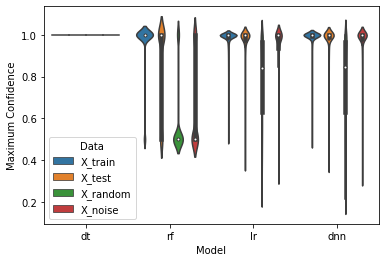

In [104]:
sns.violinplot(data=df_conf, x='model_type', y='conf', hue='conf_type')
plt.xlabel("Model")
plt.ylabel("Maximum Confidence")
plt.legend(title='Data')
plt.show()

In [117]:
groups = df_conf.groupby(['model_type', 'conf_type'])
for k,g in groups:
    print('Model: {}, Data: {}, Mean: {}, Var: {}'.format(k[0], k[1], np.mean(g['conf']), np.var(g['conf'])))

Model: dnn, Data: X_noise, Mean: 0.955616964095831, Var: 0.010738646307518727
Model: dnn, Data: X_random, Mean: 0.7860868485033512, Var: 0.03848793794477035
Model: dnn, Data: X_test, Mean: 0.9667935845788794, Var: 0.00802236749553484
Model: dnn, Data: X_train, Mean: 0.9802948656948982, Var: 0.0044156509333877275
Model: dt, Data: X_noise, Mean: 1.0, Var: 0.0
Model: dt, Data: X_random, Mean: 1.0, Var: 0.0
Model: dt, Data: X_test, Mean: 1.0, Var: 0.0
Model: dt, Data: X_train, Mean: 1.0, Var: 0.0
Model: lr, Data: X_noise, Mean: 0.9306041561746621, Var: 0.01700163722290432
Model: lr, Data: X_random, Mean: 0.7869499182289316, Var: 0.03713342468068362
Model: lr, Data: X_test, Mean: 0.9590663603334257, Var: 0.008888736173933116
Model: lr, Data: X_train, Mean: 0.9785964832801664, Var: 0.0036976115850798448
Model: rf, Data: X_noise, Mean: 0.6478, Var: 0.05205516
Model: rf, Data: X_random, Mean: 0.5789, Var: 0.03322479
Model: rf, Data: X_test, Mean: 0.8729216152019003, Var: 0.047390276516155974
M

/Users/aatrey/Desktop/GradSchool/Research/private-ondevice-ml/venv/lib/python3.6/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/Users/aatrey/Desktop/GradSchool/Research/private-ondevice-ml/venv/lib/python3.6/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/Users/aatrey/Desktop/GradSchool/Research/private-ondevice-ml/venv/lib/python3.6/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/Users/aatrey/Desktop/GradSchool/Research/private-ondevice-ml/venv/lib/python3.6/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping dens

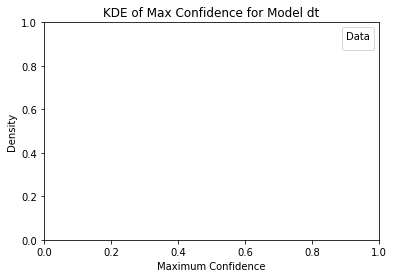

No handles with labels found to put in legend.


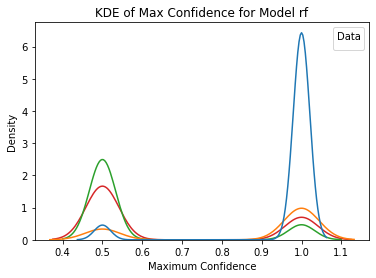

No handles with labels found to put in legend.


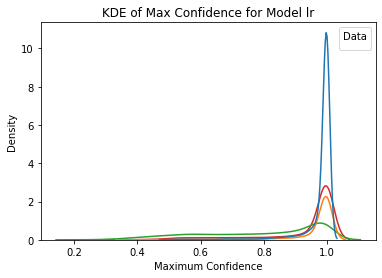

No handles with labels found to put in legend.


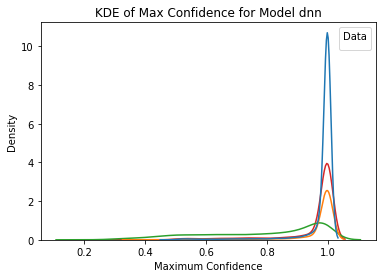

<Figure size 432x288 with 0 Axes>

In [72]:
df_conf = df_conf.reset_index()
for model in df_conf['model_type'].unique():
    sns.kdeplot(data=df_conf[df_conf['model_type']==model], x='conf', hue='conf_type')
    plt.xlabel("Maximum Confidence")
    plt.ylabel("Density")
    plt.legend(title='Data')
    plt.title('KDE of Max Confidence for Model {}'.format(model))
    plt.show()
    plt.clf()